In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.test_functions import Branin
import pandas as pd

In [3]:
import gpytorch as gp
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ZeroMean

In [4]:
import sys
import os

sys.path.append(os.path.abspath('../src'))

In [5]:
torch.manual_seed(42)

In [6]:
# Branin function
branin = Branin(negate=False)

# Radial sigma(x)
def sigma_radial(x):
    center = torch.tensor([2.5, 7.5], device=x.device)
    radius = torch.norm(x - center, dim=-1)
    max_radius = torch.sqrt(torch.tensor(2.0)) / 2
    return 0.1 + 0.4 * (radius / max_radius)

def plot(ax, data, title):
    c = ax.contourf(x1_np, x2_np, data, levels=50)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    fig.colorbar(c, ax=ax)

In [7]:
x1_vals = torch.linspace(-5, 10, 31)
x2_vals = torch.linspace(0, 15, 31)
x1_grid, x2_grid = torch.meshgrid(x1_vals, x2_vals, indexing='ij')
x = torch.stack([x1_grid.reshape(-1), x2_grid.reshape(-1)], dim=-1)

In [8]:
f_x = branin(x)
sigma_x = sigma_radial(x)

lam = 1.0
noise = lam * sigma_x * torch.randn_like(f_x)
F_x = f_x + noise

In [9]:
f_x_grid = f_x.reshape(31, 31).numpy()
sigma_x_grid = sigma_x.reshape(31, 31).numpy()
noise_grid = noise.reshape(31, 31).numpy()
F_x_grid = F_x.reshape(31, 31).numpy()
x1_np = x1_grid.numpy()
x2_np = x2_grid.numpy()

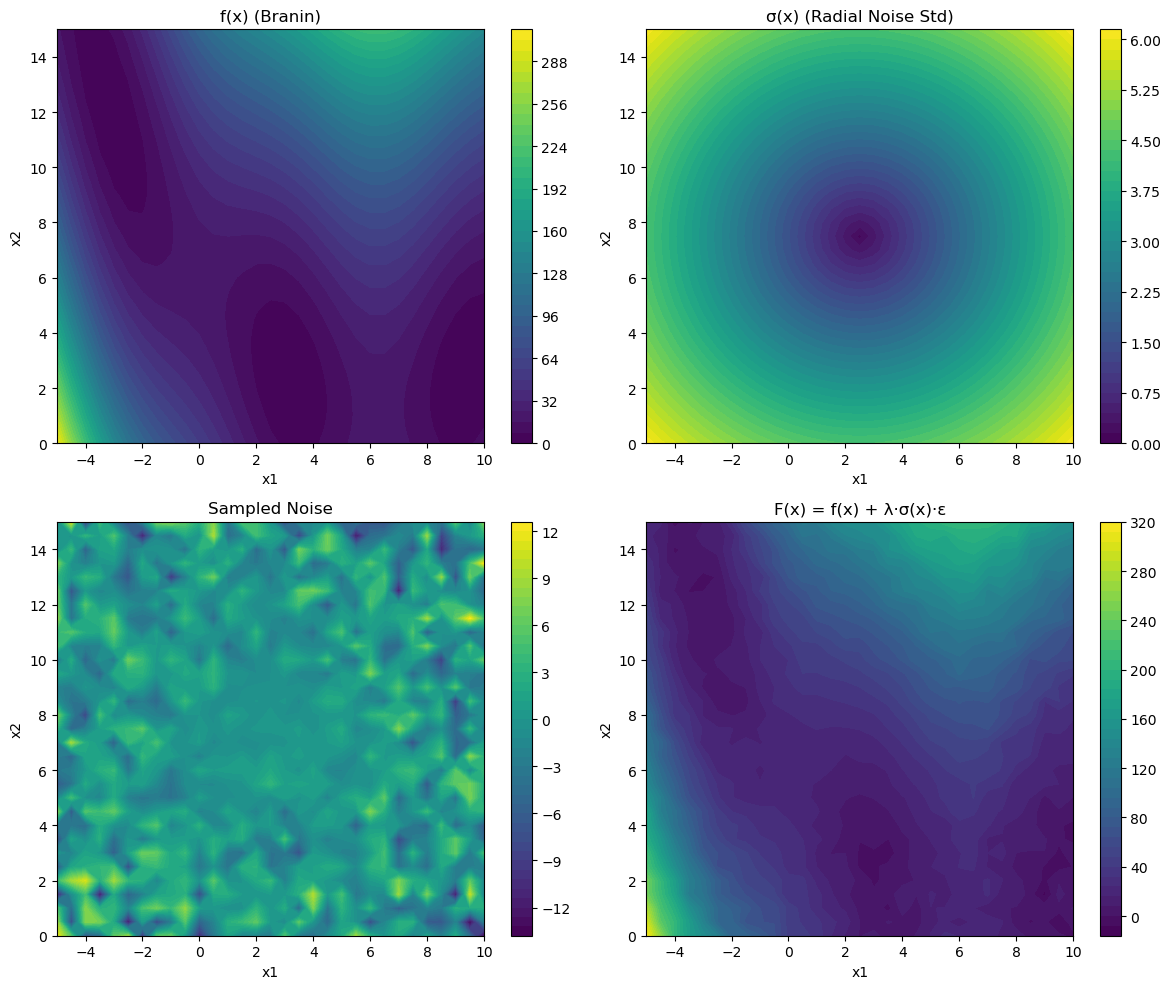

In [10]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot(axs[0, 0], f_x_grid, "f(x) (Branin)")
plot(axs[0, 1], sigma_x_grid, "σ(x) (Radial Noise Std)")
plot(axs[1, 0], noise_grid, "Sampled Noise")
plot(axs[1, 1], F_x_grid, "F(x) = f(x) + λ·σ(x)·ε")

plt.tight_layout()
plt.show()

In [11]:
y = F_x.unsqueeze(-1)
yvar = (lam * sigma_x).pow(2).unsqueeze(-1)

In [12]:
perm = torch.randperm(x.shape[0])
train_idx = perm[:25]
test_idx = perm[25:]

In [13]:
train_x = x[train_idx]
train_y = y[train_idx]
train_yvar = yvar[train_idx]

test_x = x[test_idx]
test_y = y[test_idx]
test_yvar = yvar[test_idx]

In [14]:
def get_single_task_gp(X, Y):
    '''
    SingleTask GP: noise is *learned* from data.
    '''
    if X.ndim < 2:
        print("Need to specify as matrix of size ntrain by ninputs")

    if Y.ndim == 1:
        Y = Y.unsqueeze(-1)

    input_dim = X.shape[-1]

    outcome_transform = Standardize(m=Y.shape[-1])

    model = SingleTaskGP(
        train_X=X,
        train_Y=Y,
        covar_module=ScaleKernel(RBFKernel(ard_num_dims=input_dim)),
        mean_module=ZeroMean(batch_shape=torch.Size([])),
        input_transform=Normalize(d=X.shape[-1]),
        outcome_transform=outcome_transform,
    )

    return model


def train_gp(model):
    model.outcome_transform.eval()
    mll = gp.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    model.eval()
    return model

In [15]:
model = get_single_task_gp(train_x, train_y)
model = train_gp(model)

In [16]:
with torch.no_grad():
    posterior = model.posterior(test_x)
    pred_mean = posterior.mean.squeeze()
    pred_var = posterior.variance.squeeze()

In [17]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_y, pred_mean.detach().numpy())
rmse = np.sqrt(mean_squared_error(test_y, pred_mean.detach().numpy()))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.8502
RMSE: 21.1151


In [18]:
from UQtools import order_sig_and_errors, get_slope_metric, spearman_rank_corr, expected_rho, calibration_curve, calibration_area, plot_calibration_curve, plot_Z_scores, NLL

In [19]:
data = np.column_stack((test_y.detach().numpy(), pred_mean.detach().numpy(), np.sqrt(pred_var.detach().numpy())))

df = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])
df['error'] = df['pred_y'] - df['test_y']

rho_rank = 0.68
rho_rank_sim = 0.60 +/- 0.02
miscalibration area = 0.13
NLL = 4.15
NLL_sim = 3.12 +/- 0.02
R squared: 0.9806008535284763
intercept: -3.3579645
slope: 2.3844926


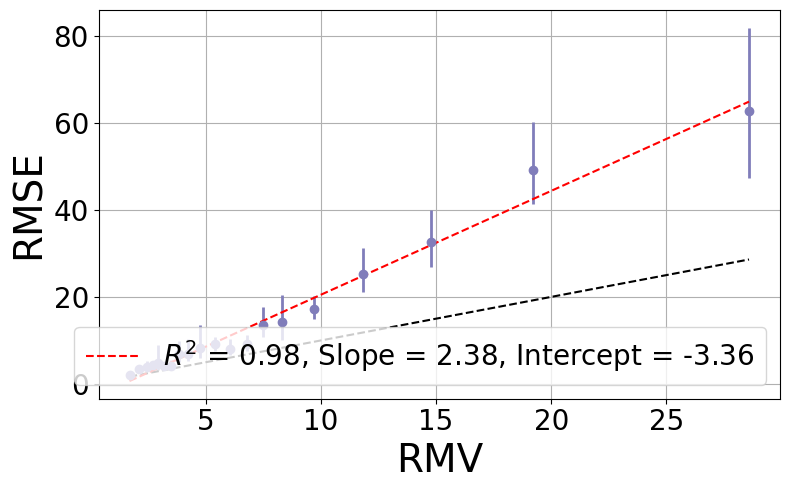

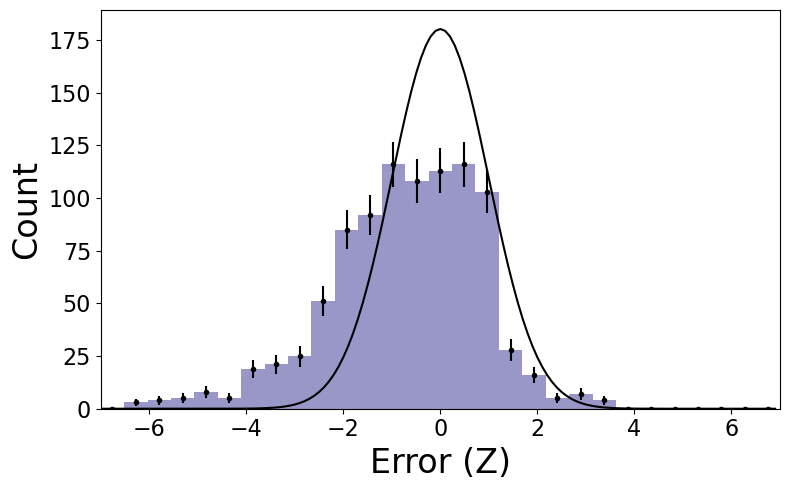

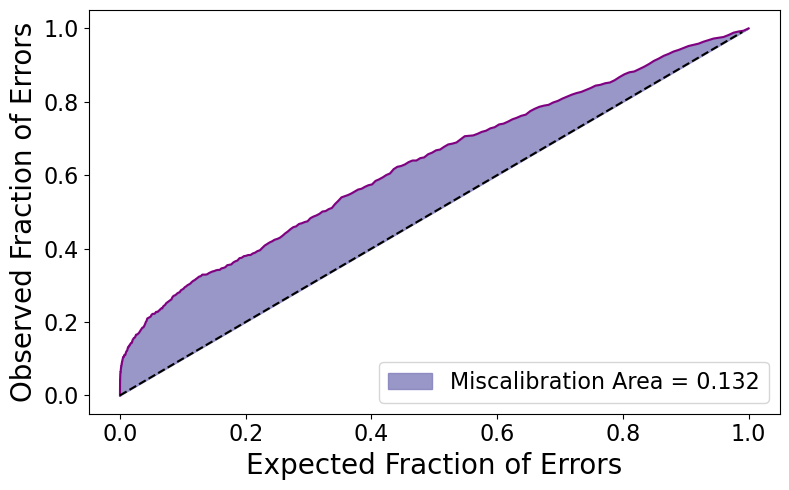

In [20]:
#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(df.uq, df.error)

#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(df.error), df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(df.uq, df.error)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

#Generate error-based calibration plot
fig, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)